In [1]:
import math
import numpy as np
import statsmodels.stats.power as smp
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd


np.random.seed(42)
plt.style.use("ggplot")

# Семинар 3

План семинара:
1. Бутстрап – идея метода
2. Доверительные интервалы - чем полезны, какие бывают
3. Проверка гипотез с помощью бутстрапа

# 1. Бутстреп – идея метода

## 1.1 Теория - сходимость ЭФР к истинной функции распределения

**Почему работает бутстрап**

Идея бутстрапа: мы хотим понять распределение некоторой статистики (среднего, конверсии, медианы и т.д.) при повторных экспериментах, но у нас есть только **одна выборка** и неизвестное истинное распределение данных.

Бутстрап делает ключевое предположение:

> если выборка репрезентативна, то распределение ее статистик похоже на распределение в генеральной совокупности.

Тогда можно:
- многократно пересэмплировать наблюдения из нашей выборки
- получать распределение интересующей статистики

**Эмпирическая функция распределения (ЭФР)**

Пусть есть выборка:

$$
X_1, X_2, ..., X_n \sim F
$$

где $F(x)$ — неизвестная функция распределения.

Эмпирическая функция распределения по определению:

$$
F_n(x) = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}(X_i \le x)
$$

Это просто доля наблюдений в выборке, меньших или равных $x$.


**Ключевой теоретический факт**

Теорема Гливенко–Кантелли:

$$
\sup_x |F_n(x) - F(x)| \rightarrow 0 \quad \text{при } n \rightarrow \infty
$$

То есть эмпирическая функция распределения **равномерно сходится** к истинной.

Интуитивно:
- чем больше выборка,
- тем лучше её распределение приближает реальное.


**Связь с бутстрапом**

В бутстрапе:

1. Истинное распределение $F(x)$ неизвестно
2. Мы заменяем его на эмпирическое $F_n(x)$
3. Генерируем новые выборки из $F_n(x)$

То есть:

$$
F(x) \approx F_n(x)
$$

А значит распределение статистики в бутстрапе приближает распределение статистики в реальных повторных экспериментах.

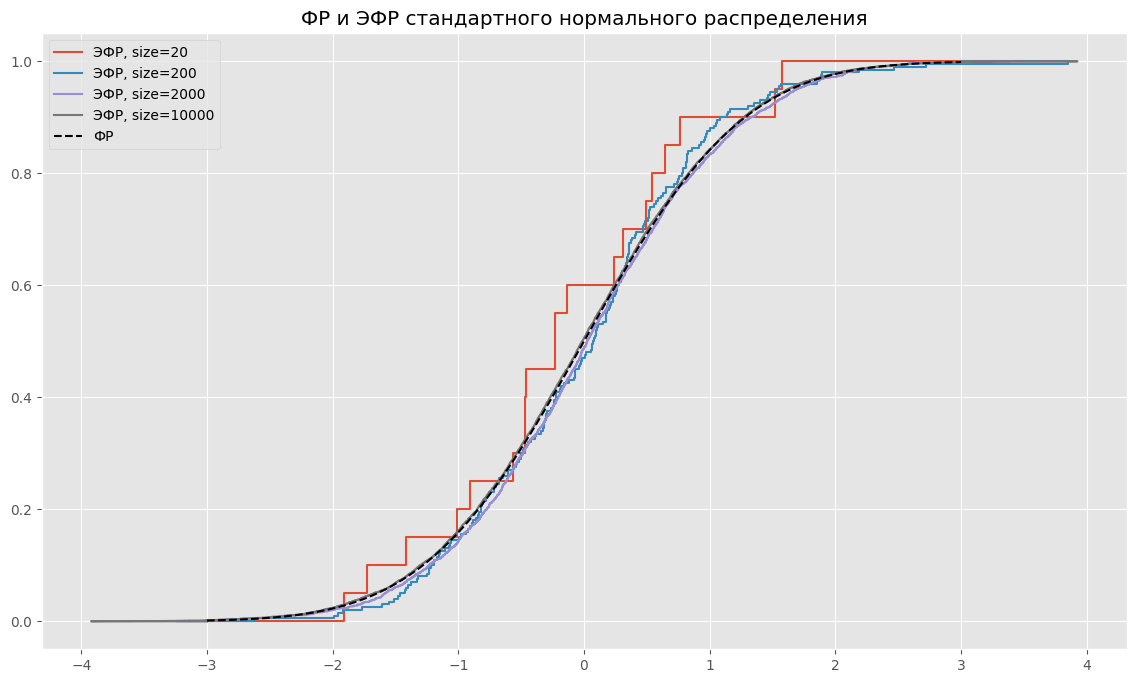

In [2]:
# https://habr.com/ru/companies/X5Tech/articles/679842/
def plot_ecdf(values, label, xlim):
    """Построить график ЭФР."""
    X_ = sorted(set(values))
    Y_ = [np.mean(values <= x) for x in X_]
    X = [xlim[0]] + sum([[v, v] for v in X_], []) + [xlim[1]]
    Y = [0, 0] + sum([[v, v] for v in Y_], [])
    plt.plot(X, Y, label=label)


plt.figure(figsize=(14, 8))
# Генерируем данные и строим ЭФР
for size in [20, 200, 2000, 10_000]:
    values = np.random.normal(size=size)
    plot_ecdf(values, f"ЭФР, size={size}", [-3, 3])

# Строим ФР
X = np.linspace(-3, 3, 1000)
Y = stats.norm.cdf(X)
plt.plot(X, Y, "--", color="k", label="ФР")

plt.title("ФР и ЭФР стандартного нормального распределения")
plt.legend()
plt.show()

## 1.2 Преимущества и недостатки метода

**Преимущества бутстрапа**

- **Подходит для любой статистики**  
  Не требует аналитической формулы распределения статистики. Можно применять к среднему, медиане, квантилям, ratio-метрикам и сложным пользовательским метрикам

- **Интерпретируем и интуитивно понятен**  
  Логика простая: считаем, что выборка — «мини-популяция» и имитируем повторные эксперименты через пересэмплирование

- **Минимум теоретических предположений**  
  Не требует нормальности распределения или больших выборок, как многие классические тесты

**Недостатки бутстрапа**

- **Вычислительно дорогой**  
  Требует тысячи и десятки тысяч пересэмплирований, что может быть тяжело на больших данных или сложных метриках. Это основное ограничение метода

- **Чувствителен к качеству исходной выборки**  
  Если выборка:
  - маленькая,
  - нерепрезентативная,
  - содержит сильные выбросы,  
  то бутстрап будет воспроизводить те же проблемы

- **Может давать смещённые оценки для некоторых статистик**  
  Особенно на малых выборках или для статистик на границе области определения

## 1.3 Пример – бутстрап для квантиля

**Пример: бутстрап для квантиля одной выборки**

Задача: оценить 90-й перцентиль метрики в одной выборке и построить доверительный интервал.

Пусть есть выборка:

$X = \{X_1, ..., X_n\}$

Интересующая статистика:

$T = q_{0.9}(X)$

где $q_{0.9}$ — 90-й перцентиль.

Для квантиля нет простой универсальной формулы дисперсии, поэтому используем бутстрап.

**Алгоритм**

Повторяем $B$ раз (например, 5000–10000):

1. Сэмплируем с возвращением из исходной выборки → $X^*$
2. Считаем статистику:
   
   $T^* = q_{0.9}(X^*)$

3. Сохраняем $T^*$

В итоге получаем набор:

$T_1^*, T_2^*, ..., T_B^*$

Это бутстрап-распределение оценки 90-го перцентиля.

**Что дальше**

- 95% доверительный интервал $1 - \alpha$:  
  $[q_{0.025}(T^*),\; q_{0.975}(T^*)]$

Этот интервал даёт оценку неопределённости для 90-го перцентиля в генеральной совокупности.

**Почему здесь удобен бутстрап**

- нет простой формулы для дисперсии квантиля
- распределение оценки может быть асимметричным
- бутстрап даёт интервал напрямую через пересэмплирование

Просимулируем этот пример

In [3]:
n = 1000  # размер исходной выборки
B = 5000  # количество генерируемых подвыборок

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))
std = np.std(bootstrap_quantiles)
print(f"Оценка 90% квантиля: {quantile:0.2f}")
print(f"Оценка std для 90% квантиля: {std:0.2f}")
print(
    f"Доверительный интервал для 90% квантиля: [{quantile - 1.96 * std:0.2f}, {quantile + 1.96 * std:0.2f}]"
)

Оценка 90% квантиля: 116.16
Оценка std для 90% квантиля: 1.03
Доверительный интервал для 90% квантиля: [114.14, 118.19]


## 1.4 Практические рекомендации
Обратим внимание на два момента:

1. Чтобы оценка стандартного отклонения была несмещённой, необходимо генерировать выборки такого же размера, как и размер исходной выборки;
2. Количество итераций бутстрепа рекомендуется брать в диапазоне от 1000 до 10000. Этого, как правило, хватает для получения достаточно точных результатов.

Второй пункт понятен, но разберем подробнее первый. **Почему в бутстрапе пересэмплируют выборки того же размера?**

Пусть у нас есть исходная выборка:

$X_1, X_2, ..., X_n$

и мы хотим оценить распределение статистики $T(X_1, ..., X_n)$  
(например, среднего, медианы, квантиля)

---- 

**Что имитирует бутстрап?** Бутстрап пытается воспроизвести ситуацию:

> «Если бы мы снова провели эксперимент и получили новую выборку того же размера $n$ из той же популяции»

В реальности при повторном эксперименте:

- мы снова получим **$n$ наблюдений**,
- из того же распределения $F(x)$,
- и посчитаем статистику на выборке размера $n$.

Именно это и должен имитировать бутстрап

---

**Что будет, если менять размер?**

Если брать:

- меньшие выборки -> дисперсия статистики будет **завышена**
- большие выборки -> дисперсия будет **занижена**

Потому что дисперсия большинства статистик зависит от размера выборки:

$\mathrm{Var}(\bar X) \propto \frac{1}{n}$

То есть мы начнём имитировать **другой эксперимент**, с другим числом наблюдений

---

**Интуитивно**

Бутстрап отвечает на вопрос:

> «Как бы вела себя статистика, если бы мы много раз повторили тот же эксперимент?»

А «тот же эксперимент» означает:

- тот же процесс генерации данных
- и тот же размер выборки


Покажем на примере, как поменяется распределение дисперсии при разного размера подвыборках


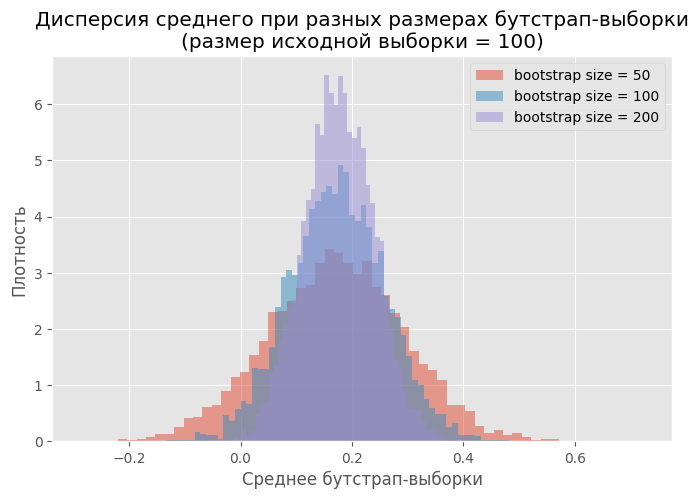

bootstrap size = 50, var(mean) = 0.01496
bootstrap size = 100, var(mean) = 0.00742
bootstrap size = 200, var(mean) = 0.00388


In [4]:
# исходная выборка
n = 100
data = np.random.normal(loc=0, scale=1, size=n)

# размеры бутстрап-выборок
bootstrap_sizes = [50, 100, 200]
n_boot = 5000

bootstrap_means = {}

for size in bootstrap_sizes:
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=size, replace=True)
        means.append(sample.mean())
    bootstrap_means[size] = np.array(means)

# график
plt.figure(figsize=(8, 5))

for size in bootstrap_sizes:
    plt.hist(
        bootstrap_means[size],
        bins=60,
        alpha=0.5,
        density=True,
        label=f"bootstrap size = {size}",
    )

plt.title(
    f"Дисперсия среднего при разных размерах бутстрап-выборки\n(размер исходной выборки = {n})"
)
plt.xlabel("Среднее бутстрап-выборки")
plt.ylabel("Плотность")
plt.legend()
plt.show()

# численные дисперсии
for size in bootstrap_sizes:
    print(f"bootstrap size = {size}, var(mean) = {bootstrap_means[size].var():.5f}")

Дисперсия очень смещается, если нарушать предпосылки бутстрапа – мы максимально "повторяем" эксперимент, в ходе которого получена наблюдаемая выборка. Значит параметры остаются теми же

# 2. Доверительный интервал для оценки статистики

## 2.1 Типы интервалов

**Зачем нужны доверительные интервалы**

Точечная оценка (например, среднее или квантиль) — это всего лишь одно число, полученное на конкретной выборке. Как правило, его недостаточно для интерпретации результатов и требуется построить доверительный интервал. Существуют несколько способов посчитать ДИ. Они, конечно, справедливы для любой задачи оценки статистики, не только для бутстрапа (бутстрап – лишь способ сгенерировать распределение)

1. **Нормальный ДИ**  
   $\hat\theta \pm z_{1-\alpha/2} \cdot \widehat{se}$  
   где дисперсия оценивается по бутстрап-выборкам.

   Когда использовать:
   - распределение статистики близко к нормальному,
   - выборка достаточно большая,
   - статистика «гладкая» (например, среднее).

2. **Перцентильный ДИ**  
   $[q_{\alpha/2},\; q_{1-\alpha/2}]$  
   Просто берём квантили бутстрап-распределения.

   Когда использовать:
   - распределение статистики асимметрично,
   - нет уверенности в нормальности,
   - нужна простая и устойчивая оценка.

3. **Центральный (pivotal) ДИ**  
   $[2\hat\theta - q_{1-\alpha/2},\; 2\hat\theta - q_{\alpha/2}]$

   Идея: отражаем бутстрап-распределение относительно точечной оценки.

   Когда использовать:
   - распределение статистики смещено относительно точки оценки,
   - хотим частично скорректировать смещение.

## 2.2 Когда применять?

**Когда какой интервал применять?**

- Если распределение статистики похоже на нормальное -> нормальный ДИ.
- Если оно асимметрично или неизвестно -> перцентильный ДИ.
- Если заметно смещение -> можно попробовать центральный ДИ.

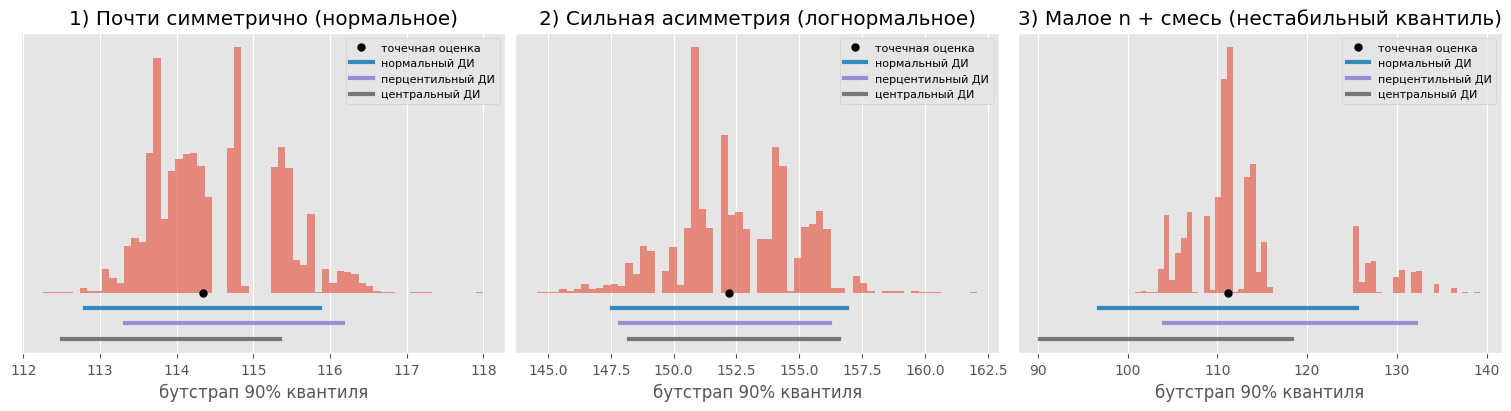

In [5]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """Строит нормальный доверительный интервал."""
    z = stats.norm.ppf(1 - alpha / 2)
    # стандартная ошибка - это стандартное отклонение бутстрап-статистик
    # с ddof=1, чтобы получить несмещенную оценку
    se = np.std(bootstrap_stats, ddof=1)
    left, right = pe - z * se, pe + z * se
    return left, right


def get_percentile_ci(bootstrap_stats, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right


def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """Строит центральный доверительный интервал."""
    left, right = 2 * pe - np.quantile(bootstrap_stats, [1 - alpha / 2, alpha / 2])
    return left, right


alpha = 0.05
B = 10000
q = 0.9


def bootstrap_quantiles(values, B, q):
    n = len(values)
    boot_samples = np.random.choice(values, size=(B, n), replace=True)
    return np.quantile(boot_samples, q, axis=1)


def plot_case(ax, values, title):
    pe = np.quantile(values, q)
    boot_stats = bootstrap_quantiles(values, B, q)

    normal_ci = get_normal_ci(boot_stats, pe, alpha)
    percentile_ci = get_percentile_ci(boot_stats, alpha)
    pivotal_ci = get_pivotal_ci(boot_stats, pe, alpha)

    ax.hist(boot_stats, bins=60, density=True, alpha=0.6)
    ax.plot([pe], [0], "o", c="k", markersize=5, label="точечная оценка")

    # рисуем интервалы чуть ниже оси
    y_max = ax.get_ylim()[1]
    d = 0.06 * y_max
    ax.plot(normal_ci, [-d, -d], linewidth=3, label="нормальный ДИ")
    ax.plot(percentile_ci, [-2 * d, -2 * d], linewidth=3, label="перцентильный ДИ")
    ax.plot(pivotal_ci, [-3 * d, -3 * d], linewidth=3, label="центральный ДИ")

    ax.set_title(title)
    ax.set_xlabel(f"бутстрап {int(q*100)}% квантиля")
    ax.set_yticks([])
    ax.legend(fontsize=8, loc="upper right")


# 1) Почти симметричное распределение
values1 = np.random.normal(loc=90, scale=20, size=2000)

# 2) Скошенное распределение (логнормальное)
values2 = np.random.lognormal(mean=4.4, sigma=0.5, size=2000)

# 3) Маленькая выборка + смесь (нестабильность/асимметрия для квантиля)
n3 = 250
mix = np.random.choice([0, 1], size=n3, p=[0.9, 0.1])
values3 = np.random.normal(90, 10, n3) + mix * np.random.normal(60, 10, n3)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
plot_case(axes[0], values1, "1) Почти симметрично (нормальное)")
plot_case(axes[1], values2, "2) Сильная асимметрия (логнормальное)")
plot_case(axes[2], values3, "3) Малое n + смесь (нестабильный квантиль)")
plt.show()

# 3. Проверка гипотез с помощью бутстрепа

## 3.1 Через доверительный интервал

**Проверка гипотез с помощью бутстрапа**

Хотим проверить $H_0$: метрика в группах A и B одинакова (например, 90-й квантиль), против $H_1$: есть отличие.

Идея: строим бутстрап-распределение разности метрик  
$T = q_{0.9}(B) - q_{0.9}(A)$ и 95% доверительный интервал для $T$.

Критерий на уровне значимости $\alpha$:
- если $0 \notin CI$, то отвергаем $H_0$ (различия статистически значимы),
- если $0 \in CI$, то оснований отвергать $H_0$ нет.

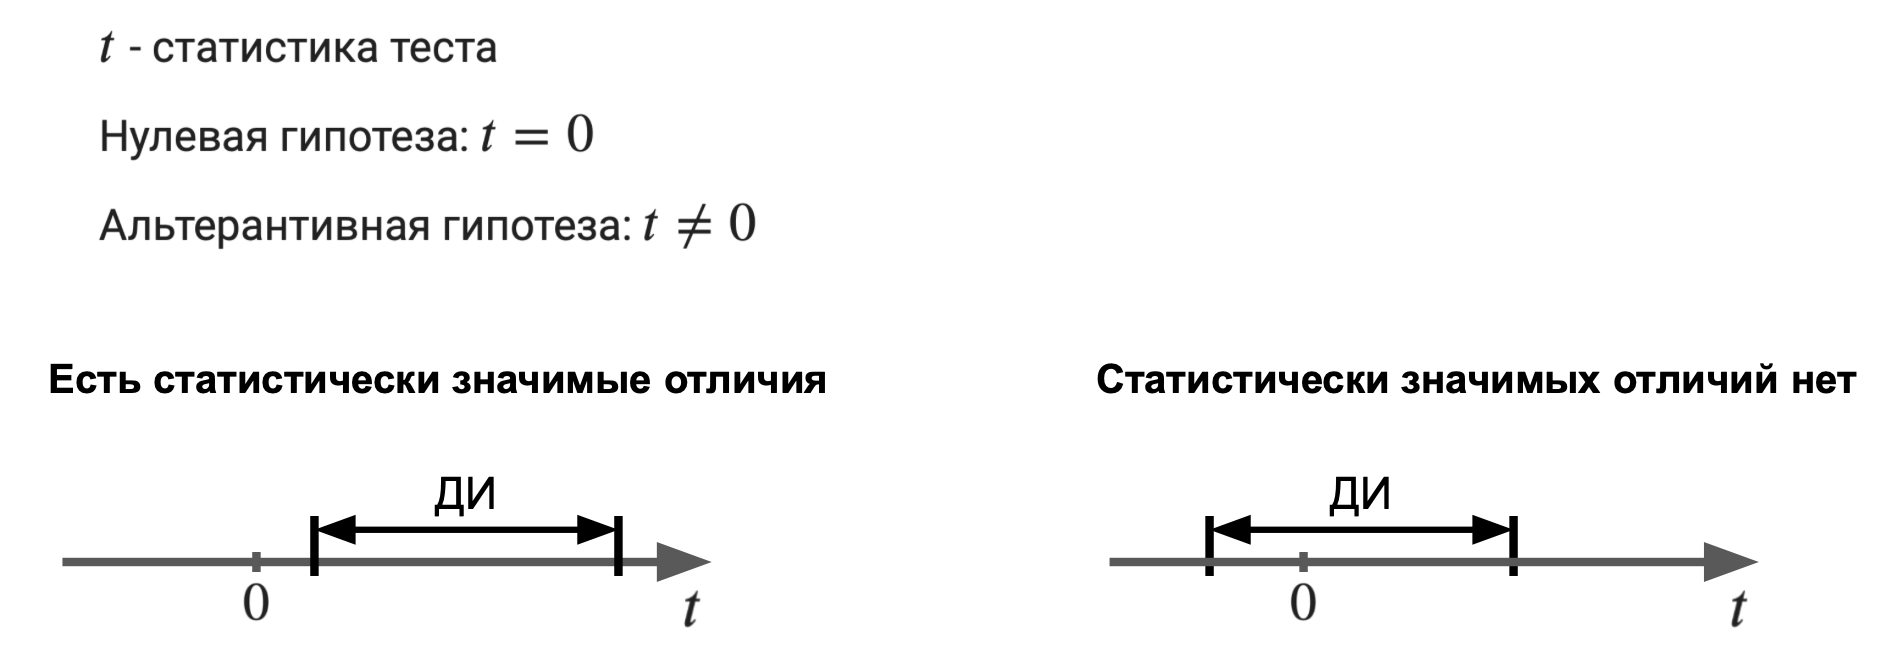

Пример: симулируем эксперимент для 90-го квантиля: пересэмплируем обе группы, считаем квантиль, берём разность, строим перцентильный ДИ.

Разность 90% квантилей (B - A): 4.26
95% ДИ (перцентильный): (1.36, 7.14)
Статистически значимо на уровне α=0.05: True


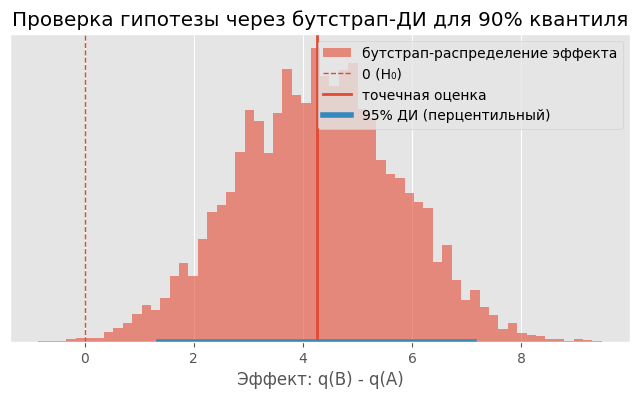

In [ ]:
n = 1000
B = 10000
alpha = 0.05
q = 0.9

# Пример: группы с одинаковым средним, но разной дисперсией
# то есть симулируем ситуацию, когда 90% квантиль мог измениться из-за роста дисперсии
values_a = np.random.normal(90, 15, n)
values_b = np.random.normal(90, 20, n)

# точечная оценка эффекта
pe = np.quantile(values_b, q) - np.quantile(values_a, q)

# бутстрап-распределение эффекта
boot_a = np.random.choice(values_a, size=(B, n), replace=True)
boot_b = np.random.choice(values_b, size=(B, n), replace=True)

boot_q_a = np.quantile(boot_a, q, axis=1)
boot_q_b = np.quantile(boot_b, q, axis=1)

bootstrap_stats = boot_q_b - boot_q_a

# ДИ (оставим перцентильный как основной для квантилей)
ci = get_percentile_ci(bootstrap_stats, alpha)

has_effect = not (ci[0] <= 0 <= ci[1])

print(f"Разность {int(q*100)}% квантилей (B - A): {pe:.2f}")
print(f"{int((1-alpha)*100)}% ДИ (перцентильный): ({ci[0]:.2f}, {ci[1]:.2f})")
print(f"Статистически значимо на уровне α={alpha}: {has_effect}")

plt.figure(figsize=(8, 4))
plt.hist(
    bootstrap_stats,
    bins=60,
    density=True,
    alpha=0.6,
    label="бутстрап-распределение эффекта",
)
plt.axvline(0, linestyle="--", linewidth=1, label="0 (H₀)")
plt.axvline(pe, linewidth=2, label="точечная оценка")

y = 0
plt.plot(ci, [y, y], linewidth=4, label="95% ДИ (перцентильный)")

plt.title(f"Проверка гипотезы через бутстрап-ДИ для {int(q*100)}% квантиля")
plt.xlabel("Эффект: q(B) - q(A)")
plt.yticks([])
plt.legend()
plt.show()

## 3.2 Через p value

Кроме построения ДИ есть еще способ проверить гипотезу через бутстрап – посчитать p value.

*Как правило строят ДИ и не усложняют, но способы ниже полезно осознать*

> Короткая логика такая: p-value в бутстрапе — это доля бутстрап-выборок, в которых статистика получается не менее экстремальной, чем наблюдаемая, при условии нулевой гипотезы.

Главный момент: бутстрап нужно строить вокруг **нулевой гипотезы, а не вокруг наблюдаемой разницы**.

Чтобы это сделать, нам нужно понять **распределение статистики при верности $H_{0}$**. Этого предположения мы не вводили при построении ДИ.

Как это сделать? Есть два способа – центрирование бутстрапа и перестановки.

### 3.2.1 Центрирование

Если бутстрапить «как есть», распределение будет построено вокруг наблюдаемого эффекта, а не вокруг нуля.

Но `p-value` по определению — это вероятность получить такое или более экстремальное значение статистики при верной $H_{0}$

Поэтому нужно смоделировать мир, где эффекта нет (например, разница медиан нулевая), то есть:

$$H_0: T = 0$$

Самый простой способ:

$$T^{*(b)}_{centered} = T^{*(b)} - T$$

То есть сдвигаем бутстрап-распределение так, чтобы его центр был в нуле.
Построим распределение центрированного бутстрапа из прошлого примера и посчитаем p value

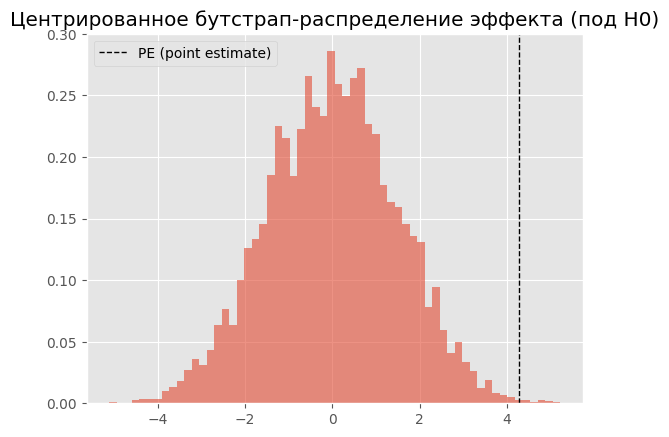

PE: 4.26, p-value (centered bootstrap): 0.0033


In [22]:
# центрирование под H0
bootstrap_centered = bootstrap_stats - pe
plt.hist(bootstrap_centered, bins=60, density=True, alpha=0.6)
plt.axvline(pe, linestyle="--", linewidth=1, color="black", label="PE (point estimate)")
plt.title("Центрированное бутстрап-распределение эффекта (под H0)")
plt.legend()
plt.show()

# двусторонний p-value
p_value = np.mean(np.abs(bootstrap_centered) >= abs(pe))

print(f"PE: {pe:.2f}, p-value (centered bootstrap): {p_value:.4f}")

### 3.2.2 Перестановки

Второй способ подробно описан [тут](https://www.alexkaizer.com/bios_6618/files/bios6618/W16/bootstrap_pvalue.pdf)

Идея метода в следующем:

> При нулевой гипотезе $H_0: \text{разницы между группами нет}$  
> **Значит, все наблюдения из теста и контроля происходят из одного распределения.**

Алгоритм:
1.	Объединяем данные из обеих групп
2.	На каждой итерации:
    - случайно **без возвращения** делим на две группы тех же размеров. То есть просто случайно ассайним группу
    - считаем статистику, например разницу квантилей
3.	Получаем распределение $T^*_{H0}$ — уже сразу при верной $H_{0}$
4.	Считаем:

$$p = P(|T^*_{H0}| \ge |T_{obs}|)$$

Построим такой же подход на нашем примере

In [15]:
pooled = np.concatenate([values_a, values_b])
perm_stats = []

for _ in range(B):
    # рандомно ассайним группы - строим распределение при H0
    perm = np.random.permutation(pooled)
    perm_a = perm[:n]
    perm_b = perm[n:]

    q_a = np.quantile(perm_a, q)
    q_b = np.quantile(perm_b, q)

    perm_stats.append(q_b - q_a)

perm_stats = np.array(perm_stats)

# двусторонний p-value
p_value_perm = np.mean(np.abs(perm_stats) >= abs(pe))

print(f"p-value (permutation): {p_value_perm:.4f}")

p-value (permutation): 0.0007


# 4. Что может пойти не так

Бутстрап плохо работает для экстремальных квантилей на небольшой выборке.
Интуиция простая: если в выборке мало наблюдений в хвосте, бутстрапу просто неоткуда брать экстремальные значения, и он даёт нестабильные или смещённые оценки.

Ниже компактная симуляция: сравниваем “истинное” распределение 99-го квантиля с бутстрап-оценкой на маленькой выборке.

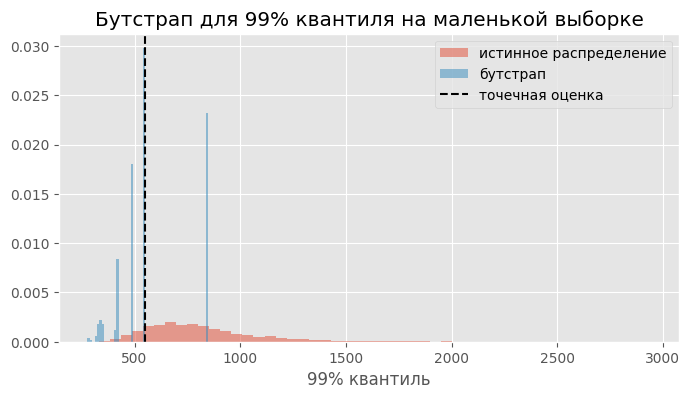

Истинная дисперсия: 77241.82400974765
Бутстрап-дисперсия: 28808.53056439521


In [9]:
# параметры
n = 100  # маленькая выборка
B = 3000  # число бутстрап-итераций
q = 0.99


# истинное распределение: тяжелый правый хвост
def generate_sample(n):
    return np.random.lognormal(mean=4.5, sigma=1.0, size=n)


# "истинное" распределение статистики через симуляцию новых выборок
true_stats = []
for _ in range(B):
    sample = generate_sample(n)
    true_stats.append(np.quantile(sample, q))

true_stats = np.array(true_stats)

# берём одну выборку и делаем бутстрап
sample = generate_sample(n)
pe = np.quantile(sample, q)

boot_stats = []
for _ in range(B):
    boot = np.random.choice(sample, size=n, replace=True)
    boot_stats.append(np.quantile(boot, q))

boot_stats = np.array(boot_stats)

plt.figure(figsize=(8, 4))
plt.hist(true_stats, bins=50, alpha=0.5, density=True, label="истинное распределение")
plt.hist(boot_stats, bins=50, alpha=0.5, density=True, label="бутстрап")
plt.axvline(pe, color="black", linestyle="--", label="точечная оценка")
plt.legend()
plt.title("Бутстрап для 99% квантиля на маленькой выборке")
plt.xlabel("99% квантиль")
plt.show()

print("Истинная дисперсия:", np.var(true_stats))
print("Бутстрап-дисперсия:", np.var(boot_stats))

Кроме экстремальных статистик бутстрап может плохо работать с зависимыми данными. В случае очевидных бизнес зависимостей и невозможности от них избавиться вообще мало что будет работать без доп. приседаний - в таком случае надо обязатель стресс тестить ваш критерий / бутстрап до запуска эксперимента (через АА, синт АB тесты, следим за равномерностью p value и нужной мощностью). Подробнее это разберем далее.

# Итог

- Бутстрап — универсальный способ оценить распределение статистики, когда нет подходящих критериев
- Идея метода: считаем выборку «мини-популяцией» и многократно пересэмплируем из неё данные
- Основные типы доверительных интервалов: нормальный, перцентильный и центральный
- Проверка гипотезы через бутстрап:
  - строим распределение эффекта,
  - строим доверительный интервал,
  - если $0 \notin CI$ → различия статистически значимы
  - также можно посчитать p value через построение распределения статистики при H0:
    - через центрирование
    - через перестановки
    - но проще использовать ДИ, и как правило его и используют
- Важно:
  - бутстрап-выборки должны быть того же размера, что и исходная выборка
  - метод чувствителен к маленьким и нерепрезентативным выборкам